# Sampling from a Multinomial Distribution

The multinomial distribution is given by:


$f(x_1,...,x_N)=\frac{n!}{x_1!\cdots x_k!} p_1^{x_1} \cdots p_k^{x_k}$

where ${p_i..p_k}$ is the set of probabilities for $n$ events.  This is a generalization of the binomial distribution.

Consider a six sided, "fair" die, where the probability of rolling any number is $1/6$.  To compute this quantity, we select a uniform random number $\xi \sim U[0,1]$, and find the corresponding location in the probability spectrum (or cumulative probability distribution), and assign the number, as shown in the diagram below.  This can also be done for the case of unequal probabilities (shown below).  For the example, we are using a biased die, where the 4 has a probability of $4/9$ while the others have a probability $1/9$.  For the first case, the random draw of 0.45 results in a roll of 3, while the second case would return a roll of 4.
 

<img src="multinomialSamplerDiagram.png" width="350">


Spark does not currently provide a multinomial sampler, so we will write our own and validate it against the numpy multinomial function.

## Evaluating a Validated Desktop Scale Function

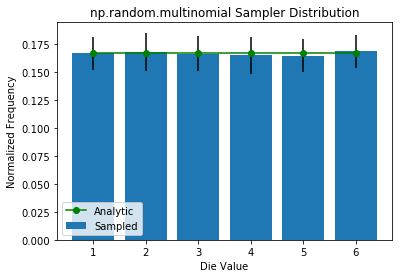

In [1]:
import numpy as np
import matplotlib.pyplot as plt

nTrials = 500 # of rolls per round
nRounds = 100 # of rounds
np.random.seed(10)
numFaces = 6

faceNames=[i for i in range(1,numFaces+1)] #assigning "values" (die face numbers) to index entries

# array for a a fair die
p1 = [1/6.]*numFaces 

# array for a biased die (4 is 4x more likely)
p2=[1/9., 1/9., 1/9., 4/9., 1/9., 1/9.] 


s1 = np.random.multinomial(nTrials, p1, size=nRounds)

# not currently used...
# s2 = np.random.multinomial(nTrials, p2, size=nRounds)

#initialization
svg = np.zeros(numFaces) 
serr = np.zeros(numFaces) 

#computing averages and standard deviations and plotting
for i in range(numFaces):
    svg[i] = np.mean(s1[:,i])/nTrials
    serr[i]  = np.std(s1[:,i])/nTrials
    
plt.title("np.random.multinomial Sampler Distribution")    
plt.bar(faceNames,svg,yerr=serr)
plt.plot(faceNames, p1, '-og')
plt.legend(['Analytic','Sampled'])
plt.xlabel("Die Value")
plt.ylabel("Normalized Frequency")
plt.show()


We can see that the histogrammed values fall within expected values to well within one standard deviation.  Since this is NumPy's builtin function, we are assusming that it works perfectly well, and that we just need to understand it's behavior. 

## Understanding the Logic to Be Used at Scale

### multinomialLocal function

Before writing our Spark function, which may have its own difficulties, let's work out the logic in our local python environment.  This will serve as a logical bridge to the pyspark implementation.

For a particular round, we will need to generate many trials and record the number of times each die value is rolled.  We need to generate these rolls with the random number generator and the probability spectrum method that was described in the above section [Sampling from a Multinomial Distribution](#Sampling from a Multinomial Distribution).
  

In [2]:
def multinomialLocal(nTrials, p, size):
      
    nRounds = size # using a more descriptive variable
    xi = np.random.uniform(size=(nTrials, nRounds))
    
    # computing the cumulative probabilities (cdf)
    pcdf = np.zeros(numFaces)
    pcdf[0] = p[0]
    
    for i in range(1, numFaces):
        pcdf[i] = p[i-1] + pcdf[i-1] 

    s = np.zeros((nRounds, numFaces))

    for iTrial in range(nTrials):
        for jRound in range(nRounds):
            index = np.where(pcdf >= xi[iTrial, jRound])[0][0]
            s[jRound, index] += 1
    
    return s

### multinomialLocal Plot
Let's plot our result and see if it looks similar to the above result.

In [3]:
svg = np.zeros(numFaces)
serr = np.zeros(numFaces)
np.random.seed(10)
sLocal = multinomialLocal(nTrials, p1, nRounds)

# same (simple) plotting code as above...
for i in range(numFaces):
    svg[i] = np.mean(sLocal[:,i])/nTrials
    serr[i] = np.std(sLocal[:,i])/nTrials
    
print(faceNames,svg)
plt.bar(faceNames,svg, yerr=serr)
plt.plot(faceNames, p1, '-og')
plt.legend(['Analytic','Sampled'])
plt.xlabel("Die Value")
plt.ylabel("Normalized Frequency")

[1, 2, 3, 4, 5, 6] [ 0.16862  0.16608  0.16492  0.16914  0.16652  0.16472]


Well, I'm convinced we got it right, but feel free to do some more testing!  Let's look at the Spark code for this.

We need to do an import and also start up our spark context.

## Writing the Scalable Code

In [4]:
import pyspark.mllib.random
sc = pyspark.SparkContext(appName="test")

### Pyspark Multinomial Function

The spark code follows the same logic, but we are now using pyspark methods which will ultimately be able to run across many CPUs.  The first function uses Spark methods (map, reduceByKey, etc.) but follows the same logic as the [Local Multinomial Function](## Local Multinomial Function).

In [5]:
# Using Spark Random number generator and 
# accumulating statistics for a single round.

def countsForSingleRound(numFaces,nTrials,seed, pcdf):
    s = np.zeros(numFaces)
    xi = pyspark.mllib.random.RandomRDDs. \
          uniformRDD(sc,nTrials,seed = seed )
    index = xi.map(lambda x: np.where(pcdf >= x)[0][0]).map(lambda x: (x,1))
    indexCounts =  \
       np.array(index.reduceByKey(lambda a,b: a + b).collect())
    # assigning counts to each location, 
    # accounting for the possiblity of zero counts in 
    # any particular value
    for i in indexCounts:
        s[i[0]]=i[1]
    return s

def multinomialSpark(nTrials, p, size):
    # setting Spark seed with numpy seed state:
    sparkSeed = int(np.random.get_state()[1][0] )
    nRounds = size
    numFaces = len(p)
    pcdf = np.zeros(numFaces)
    
    pcdf[0] = p[0]
    for i in range(1, numFaces):
            pcdf[i] = p[i-1] + pcdf[i-1] 
               
    s = np.zeros((nRounds, numFaces))
    # assume that nRounds is of reasonable size (nTrials can be very large).  
    # This means that Spark data types won't be needed.
    for iRound in range(nRounds):
        # each round is assigned a deterministic, unique seed
        s[iRound, :] = countsForSingleRound(numFaces, nTrials, sparkSeed + iRound, pcdf)
    return s

### multinomialSpark Plot

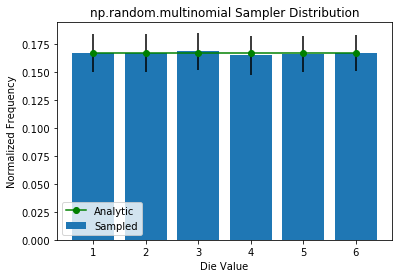

In [6]:
%matplotlib inline
np.random.seed(10)
sSpark = multinomialSpark(nTrials, p1, size=nRounds)

svg = np.zeros(numFaces)
serr = np.zeros(numFaces)

for i in range(numFaces):
    svg[i] = np.mean(sSpark[:,i])/nTrials
    serr[i] = np.std(sSpark[:,i])/nTrials
    
plt.title("np.random.multinomial Sampler Distribution")    
plt.bar(faceNames,svg,yerr=serr)
plt.plot(faceNames, p1, '-og')
plt.legend(['Analytic','Sampled'])
plt.xlabel("Die Value")
plt.ylabel("Normalized Frequency")

## Numpy Unit Test Data
Timings are also reported here...

The output that we have validated here can now be taken as pseudoranom sequence that can be used to verify that the random number generator is performing exactly as we expect.  We could use a much smaller statistical sample  as well to generate these sequences to improve calculation time (we are already using sufficiently small sample sizes here).

In [7]:
nTrialsUT = 2 # using a much smaller sample for Unit Test (faster compilation)
nRoundsUT = 5 
np.random.seed(10)
sLocal = multinomialLocal(nTrialsUT, p1, size=nRoundsUT)
print("\n first 5 rows (to be used for Unit Test)")
print(sLocal[0:5])


 first 5 rows (to be used for Unit Test)
[[ 0.  1.  0.  0.  1.  0.]
 [ 1.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  1.  0.]
 [ 0.  1.  0.  0.  1.  0.]
 [ 1.  0.  1.  0.  0.  0.]]


## Spark Unit Test Data

Spark calculations will always be much slower than the comparable single CPU process as it has lots of overhead built into it for managing large scale calculations.

In [14]:
np.random.seed(10) # need to reset the state
sSpark = multinomialSpark(nTrialsUT, p1, size = nRoundsUT)
print("\n first  5 rows (to be used for Unit Test)")
print(sSpark[0:5])


 first  5 rows (to be used for Unit Test)
[[ 1.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  1.]
 [ 0.  2.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  1.  0.]
 [ 0.  1.  1.  0.  0.  0.]]


## Writing the Unit Tests
We use the standard unittest library.  As inputs, we use the known pseudorandom sequence and the assert_array_equal method to compare the function output to the expected output. 

In [19]:
import unittest

class TestMultinomialMethods(unittest.TestCase):
    # See http://localhost:8888/notebooks/multinomialScratch.ipynb for a detailed description
    nTrials = 2
    nRounds = 5
    
    def testMultinomialLocal(self):
        np.random.seed(10)
        p = [1/6.]*6
        nTrials = 2
        nRounds = 5
        # reference data generated in notebook (preferably a github link)
        # http://localhost:8888/notebooks/multinomialScratch.ipynb#Numpy-Unit-Test-Data
        sLocalReference = np.array([[ 0., 1., 0., 0., 1., 0.],
                                    [ 1., 1., 0., 0., 0., 0.],
                                    [ 0., 0., 0., 1., 1., 0.],
                                    [ 0., 1., 0., 0., 1., 0.],
                                    [ 1., 0., 1., 0., 0., 0.]])      

        sTest = multinomialLocal(nTrials, p, size=nRounds)
        np.testing.assert_array_equal(sTest[0:5], sLocalReference)
    
    def testMultinomialSpark(self):
        np.random.seed(10)
        p = [1/6.]*6
        nTrials = 2
        nRounds = 5
        # reference data generated in notebook:
        # http://localhost:8888/notebooks/multinomialScratch.ipynb#Spark-Unit-Test-Data
        sSparkReference = np.array([[ 1., 0., 1., 0., 0., 0.],
                                    [ 0., 0., 0., 1., 0., 1.],
                                    [ 0., 2., 0., 0., 0., 0.],
                                    [ 0., 0., 0., 1., 1., 0.],
                                    [ 0., 1., 1., 0., 0., 0.]])
        
        sTest = multinomialSpark(nTrials, p, size = nRounds)
        #print(sTest)
        np.testing.assert_array_equal(sTest[0:5], sSparkReference)


In [22]:
## Running the Unit Test

In [20]:
suite = unittest.TestLoader().loadTestsFromTestCase(TestMultinomialMethods)
unittest.TextTestRunner(verbosity = 2).run(suite)

testMultinomialLocal (__main__.TestMultinomialMethods) ... ok
testMultinomialSpark (__main__.TestMultinomialMethods) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.930s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

Okay...looks good!